<a href="https://colab.research.google.com/github/musicjae/Pytorch/blob/main/Pytorch/lstm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as pdr
import datetime

# Data Load

In [2]:
start = (1999, 3, 10)
start = datetime.datetime(*start)
end = datetime.date.today()

qqq= pdr.DataReader('QQQ', 'yahoo', start, end)

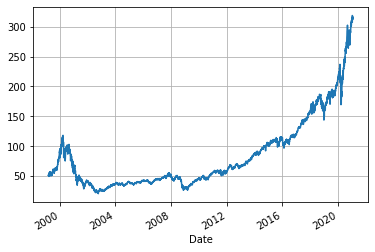

In [3]:
qqq.Close.plot(grid=True)

In [4]:
qqq.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [5]:
qqq = qqq[['Open','Close']]
print(qqq.head(3))

               Open    Close
Date                        
1999-03-10  51.1250  51.0625
1999-03-11  51.4375  51.3125
1999-03-12  51.1250  50.0625


In [6]:
qqq = qqq/ 1000 # Normalization
print(qqq.head(3))
print(qqq['Open'].values.reshape(-1,1))

                Open     Close
Date                          
1999-03-10  0.051125  0.051062
1999-03-11  0.051437  0.051312
1999-03-12  0.051125  0.050063
[[0.051125 ]
 [0.0514375]
 [0.051125 ]
 ...
 [0.3165   ]
 [0.31413  ]
 [0.31425  ]]


# Preprocessing

In [50]:
def sliding_window(data,seq_len):
    x = []
    y = []

    for i in range(len(data) - seq_len - 1):
        _x = data[i:(i+seq_len)]
        _y = data[i+seq_len]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(qqq['Close'].values.reshape(-1,1))
seq_len = 5

x,y = sliding_window(train_data, seq_len)
print(x.shape,y.shape)

train_size = int(len(y)*0.9+1) # int화 과정에서 총 데이터 개수 5496 에서 1 가 빠지길래, 그 빠진 1를 train_set에 넣어주었다.
test_size = int(len(y)*0.1)


"""
autograd.Variable은 autograd 패키지의 핵심 클래스입니다. 
Variable 클래스는 Tensor를 감싸고 있으며, Tensor에 정의된 거의 모든 연산을 지원합니다. 
모든 계산을 마친 후에 .backward()를 호출하면, 자동으로 모든 기울기가 계산됩니다.

cf: http://taewan.kim/trans/pytorch/tutorial/blits/02_autograd/
"""
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))

trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print('\n')
print(trainX.shape)
print(testX.shape)

print(trainY.shape)
print(testY.shape)

(5496, 5, 1) (5496, 1)


torch.Size([4947, 5, 1])
torch.Size([549, 5, 1])
torch.Size([4947, 1])
torch.Size([549, 1])


# Model LSTM

## use cuda

In [51]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'device:{DEVICE}')

device:cuda


In [52]:
class LSTM(nn.Module):
    def __init__(self,num_classes,input_size,hid_size,num_layers):
        super(LSTM,self).__init__()

        self.input_size = input_size
        self.hid_size = hid_size
        self.num_classes = num_classes
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size= hid_size, num_layers = num_layers, batch_first = True)
        self.fc = nn.Linear(hid_size,num_classes)

    def forward(self,x):

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hid_size)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hid_size)).to(DEVICE)

        out, (hout, _) = self.lstm(x,(h_0,c_0))
        hout = hout.view(-1,self.hid_size).to(DEVICE)
        out = self.fc(hout).to(DEVICE)

        return out

    def init_hidden(self, batch):
        return (autograd.Variable(torch.zeros(1, 1, self.hid_size).to(device)), autograd.Variable(torch.zeros(1, 1, self.hid_size).to(device)))

# Training

In [97]:
EPOCHS = 2000
LR = 0.01

INPUT_SIZE = 1
HIDDEN_SIZE = 128

NUM_LAYERS = 1
NUM_CLASSES = 1

model = LSTM(NUM_CLASSES, INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## 줍줍 모드 ##

train_losses = []
test_losses = []
correct = 0
test_loss=0

## ======= move datum into cuda ========= ##

if (torch.cuda.is_available()):

   model = model.cuda()# rnn is your model
   dataX = dataX.cuda()
   dataY = dataY.cuda()
   trainX = trainX.cuda() 
   trainY = trainY.cuda()
   testX = testX.cuda() 
   testY = testY.cuda()

## ================= Train ================= ##

for epoch in range(EPOCHS):
    
    model.train()

    model.zero_grad()
    optimizer.zero_grad()
    
    output = model(trainX)

    loss = criterion(output,trainY)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      train_losses.append(loss.item())

## ============== val ==================== ##

with torch.no_grad():
    model.eval()
    for epoch in range(1):

        testX = testX.float()
        y_pred = model(testX)
        
        test_loss += criterion(y_pred, testY).item()
        test_losses.append(test_loss)
        prediction = y_pred.max(1,keepdim=True)[1]
        correct += prediction.eq(testY.view_as(prediction)).sum().item()

test_loss /= len(testY)
test_acc = 100 * correct / len(testY)

print(f'test_loss:{test_loss}, test_acc:{test_acc}')
        

Epoch: 0, loss: 0.05774
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002
test_loss:2.7123664676267757e-07, test_acc:0.0


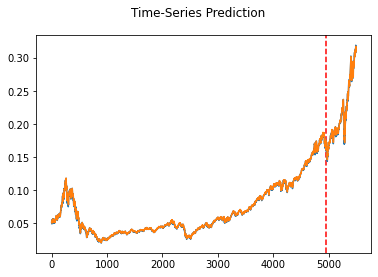

In [101]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.cpu()
dataY_plot = dataY.data.cpu()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()